In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from keras.utils import to_categorical 
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, auc, precision_score, recall_score, precision_recall_curve, roc_curve, f1_score, fbeta_score
from keras.layers import Dense
from keras.models import Sequential 
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LassoCV

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv("default of credit card clients.csv")
df=df.rename(columns={'default payment next month':'default_next_month','PAY_0':'PAY_1'})
df=df.drop('ID',axis=1)
data=df.copy()
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# EDA and organic growth

In [3]:
df1 = df.copy()

In [4]:
df1.shape

(30000, 24)

import pandas_profiling

pandas_profiling.ProfileReport(df).to_file("profile_report.html")

In [5]:
df1.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
df1['EDUCATION'].unique().tolist()

[2, 1, 3, 5, 4, 6, 0]

In [7]:
for i in ['SEX','MARRIAGE','EDUCATION']:
    print (str(i)+':'+str(sorted(df1[i].unique().tolist())))

SEX:[1, 2]
MARRIAGE:[0, 1, 2, 3]
EDUCATION:[0, 1, 2, 3, 4, 5, 6]


Labels 4,5 & 6 are classified as either unknown or 'others' for the EDUCATION column, therefore could be regrouped under a single label denoting 'others'

Similarly, the variable MARRIAGE has the label 0 as unknown

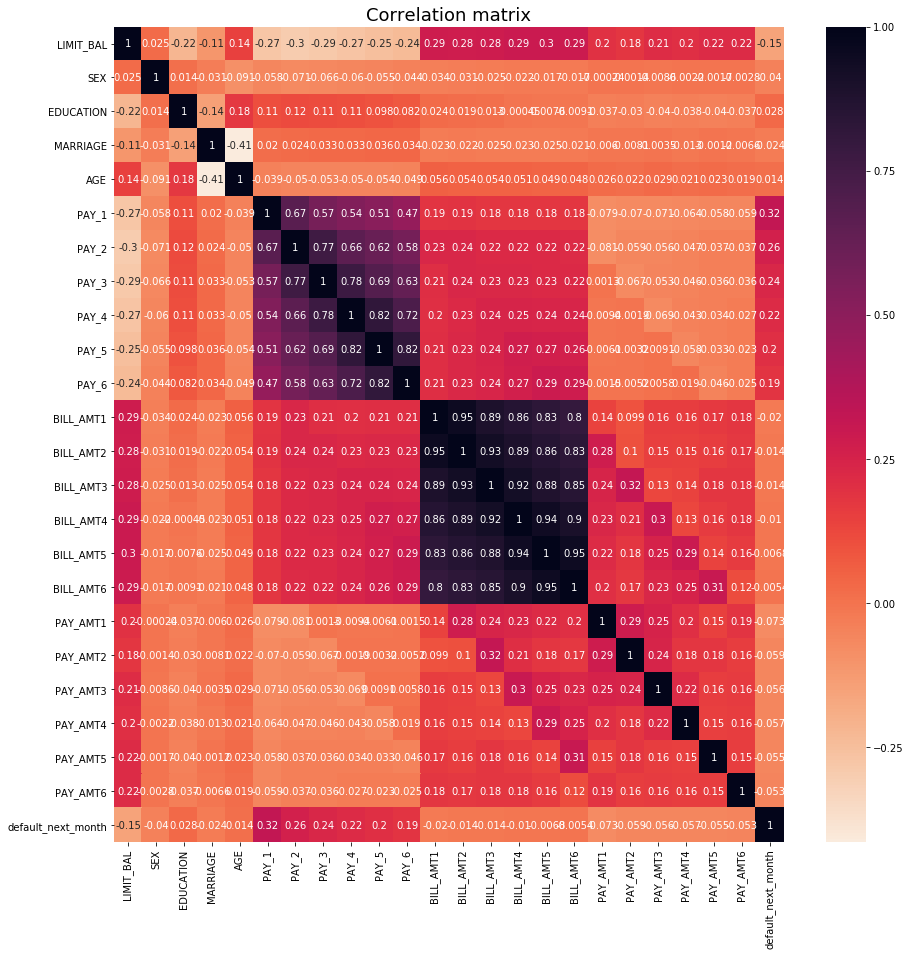

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap='rocket_r', annot=True)
plt.title("Correlation matrix", fontsize=18)
plt.savefig('corr1.png',transparent=True)

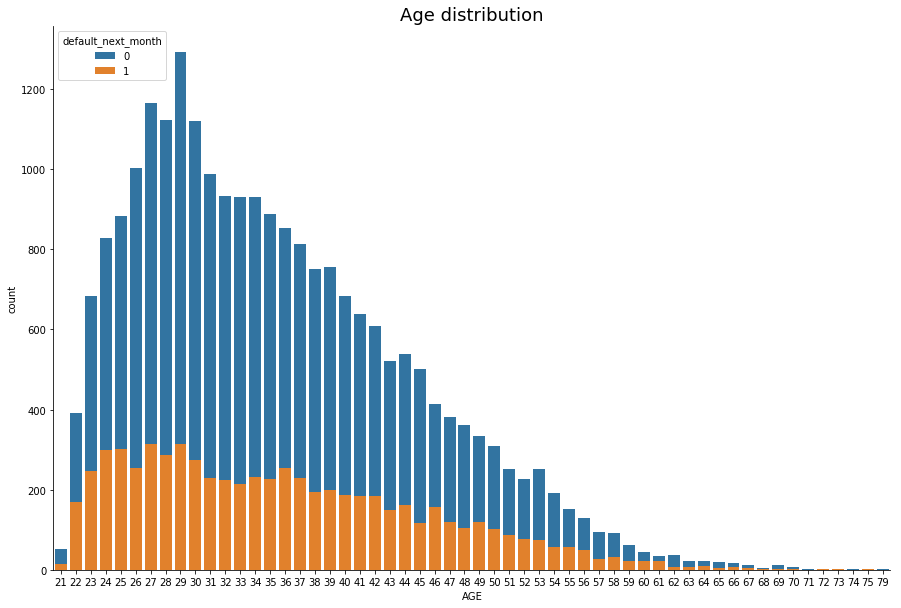

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(data=df1, x='AGE', hue='default_next_month', dodge=False)
sns.despine()
plt.title("Age distribution", fontsize=18)
plt.savefig("age_def.png", transparent= True)

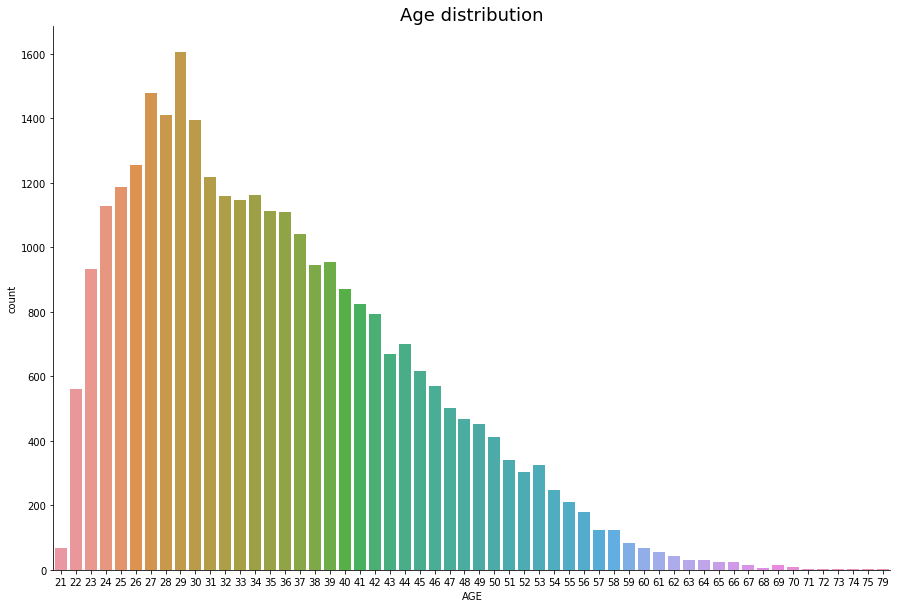

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(data=df1, x='AGE', dodge=False)
sns.despine()
plt.title("Age distribution", fontsize=18)
plt.savefig("age.png", transparent= True)

In [11]:
print(df.AGE.max())
print(df.AGE.min())
print(df.AGE.mean())

79
21
35.4855


In [12]:
df_age=pd.DataFrame(df1['AGE'].loc[df1['default_next_month'] == 0].value_counts())
df_age.columns=['no_default']
df_age['default']=df1['AGE'].loc[df1['default_next_month'] == 1].value_counts()
df_age['Total']=df1['AGE'].value_counts()
df_age['%no_default']=(df_age['no_default']/df_age['Total'])*100
df_age['%default']=(df_age['default']/df_age['Total'])*100
df_age=df_age.rename_axis('Age').reset_index()
df_age=df_age.drop(['no_default','default','Total'],axis=1)
df_age=df_age.fillna(0)
df_age=df_age.sort_values(by=['Age'],ascending=False)

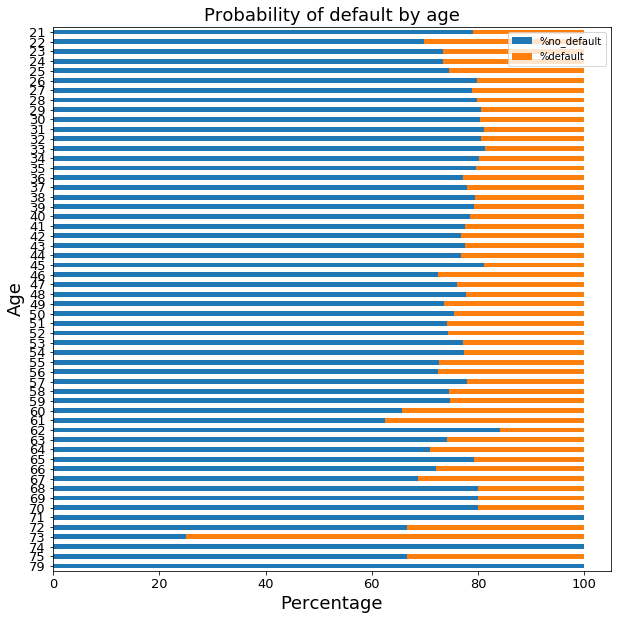

In [13]:
ax=df_age.plot(figsize=(10,10),kind='barh',x='Age', stacked=True, fontsize=13)
ax.set_title("Probability of default by age", fontsize=18)
ax.set_ylabel("Age", fontsize=18)
ax.set_xlabel("Percentage", fontsize=18)
plt.savefig("age_proba.png", transparent=True)

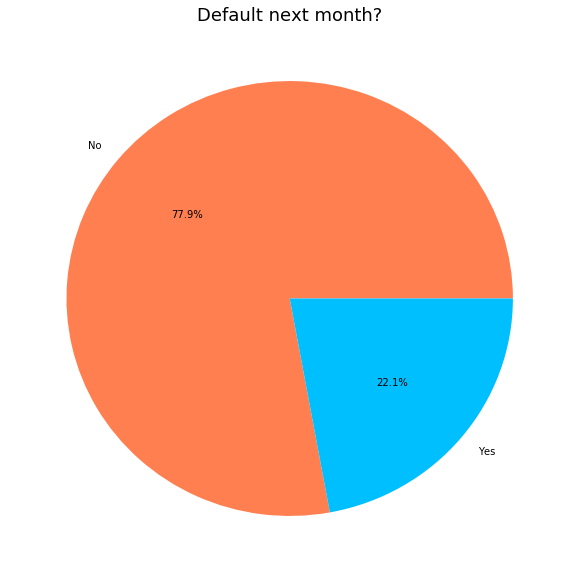

In [14]:
plt.figure(figsize=(10,10))
plt.pie(x=df1['default_next_month'].value_counts(), labels= ['No','Yes'], autopct='%1.1f%%', colors=['coral','deepskyblue'])
plt.title("Default next month?", fontsize=18)
plt.savefig("default_prop.png", transparent=True)

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state=37)
kmeans.fit(pd.DataFrame(df1['AGE']))
y_kmeans = kmeans.predict(pd.DataFrame(df1['AGE']))
df1['age_cluster']=y_kmeans

In [16]:
print('cluster0:'+str(df1.loc[df1['age_cluster']==0].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==0].AGE.max()))
df1.loc[df1['age_cluster']==0,'age_cluster']=(str(df1.loc[df1['age_cluster']==0].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==0].AGE.max()))

print('cluster1:'+str(df1.loc[df1['age_cluster']==1].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==1].AGE.max()))
df1.loc[df1['age_cluster']==1,'age_cluster']=(str(df1.loc[df1['age_cluster']==1].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==1].AGE.max()))

print('cluster2:'+str(df1.loc[df1['age_cluster']==2].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==2].AGE.max()))
df1.loc[df1['age_cluster']==2,'age_cluster']=(str(df1.loc[df1['age_cluster']==2].AGE.min())+'-'+str(df1.loc[df1['age_cluster']==2].AGE.max()))

cluster0:33-44
cluster1:45-79
cluster2:21-32


In [17]:
P_default_age=df1.loc[df1['default_next_month']==1].age_cluster.value_counts()/df1.age_cluster.value_counts()
P_default_age

21-32    0.218479
33-44    0.213403
45-79    0.244798
Name: age_cluster, dtype: float64

# Education

In [18]:
df1.loc[(df['EDUCATION']==5) | (df['EDUCATION']==6) | (df['EDUCATION']==0),'EDUCATION']=4

In [19]:
edu={1:'Graduate School',2:'University',3:'High School',4:'Others'}
for i in edu:
    df1.loc[df1['EDUCATION']==i, 'EDUCATION']=edu[i]

In [20]:
df1['EDUCATION'].value_counts()

University         14030
Graduate School    10585
High School         4917
Others               468
Name: EDUCATION, dtype: int64

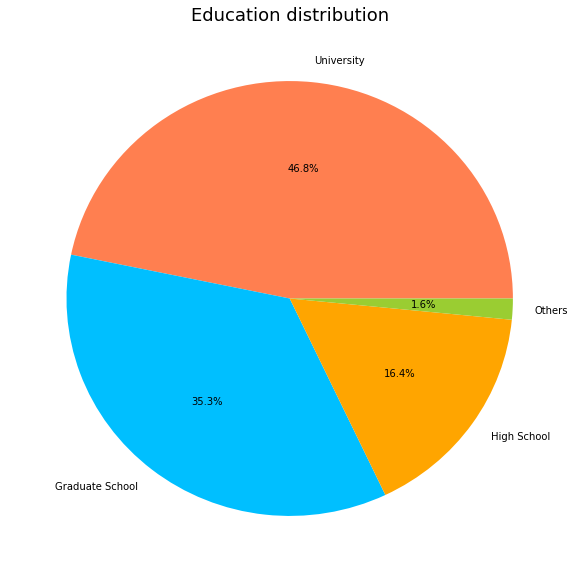

In [21]:
plt.figure(figsize=(10,10))
plt.pie(x=df1['EDUCATION'].value_counts(), labels= ['University','Graduate School','High School','Others'], autopct='%1.1f%%', colors=['coral','deepskyblue', 'orange','yellowgreen'])
plt.title("Education distribution", fontsize=18)
plt.savefig("edu_prop.png", transparent=True)

In [22]:
P_default_edu=df1.loc[df1['default_next_month']==1].EDUCATION.value_counts()/df1.EDUCATION.value_counts()
P_default_edu

University         0.237349
Graduate School    0.192348
High School        0.251576
Others             0.070513
Name: EDUCATION, dtype: float64

In [23]:
df_edu=pd.DataFrame(df1['EDUCATION'].loc[df1['default_next_month'] == 0].value_counts())
df_edu.columns=['no_default']
df_edu['default']=df1['EDUCATION'].loc[df1['default_next_month'] == 1].value_counts()
df_edu['Total']=df1['EDUCATION'].value_counts()
df_edu['%no_default']=(df_edu['no_default']/df_edu['Total'])*100
df_edu['%default']=(df_edu['default']/df_edu['Total'])*100
df_edu=df_edu.rename_axis('Level of Education').reset_index()
df_edu=df_edu.drop(['no_default','default','Total'],axis=1)
df_edu


,Level of Education,%no_default,%default
0,University,76.265146,23.734854
1,Graduate School,80.765234,19.234766
2,High School,74.842384,25.157616
3,Others,92.948718,7.051282


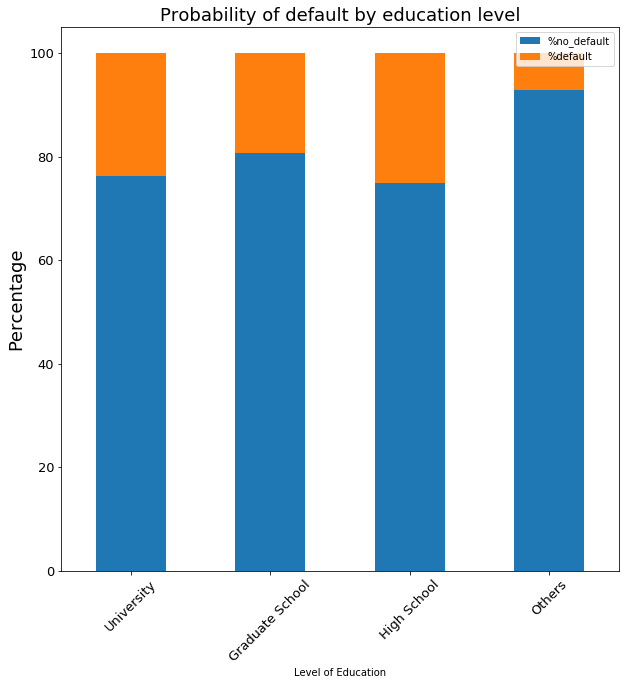

In [24]:
ax=df_edu.plot(figsize=(10,10),kind='bar',x='Level of Education', stacked=True, fontsize=13)
ax.set_title("Probability of default by education level", fontsize=18)
ax.set_ylabel("Percentage", fontsize=18)
ax.set_xticklabels(rotation=45, labels=df_edu['Level of Education'].to_list())
plt.savefig("edu_proba.png", transparent=True)

High school education highest % of default;
Others lowest

# Sex

In [25]:
gender={1:'Male',2:'Female'}
for i in gender:
    df1.loc[df1['SEX']==i, 'SEX']=gender[i]

In [26]:
df1['SEX'].value_counts()

Female    18112
Male      11888
Name: SEX, dtype: int64

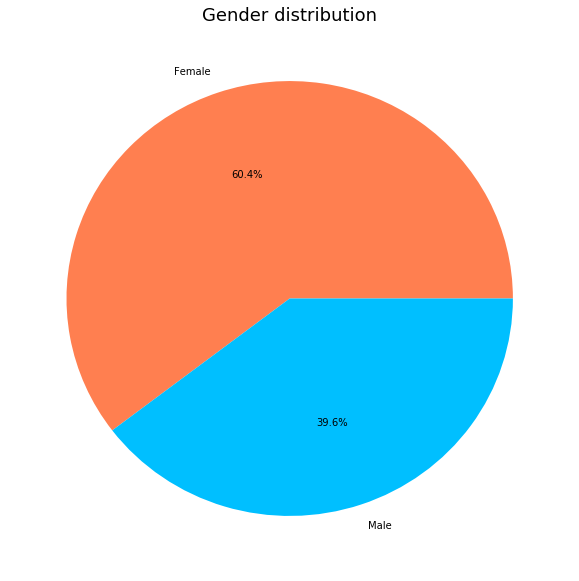

In [27]:
plt.figure(figsize=(10,10))
plt.pie(x=df1['SEX'].value_counts(), labels= ['Female','Male'], autopct='%1.1f%%', colors=['coral','deepskyblue'])
plt.title('Gender distribution', fontsize=18)
plt.savefig("gender_prop.png", transparent=True)

In [28]:
df_sex=pd.DataFrame(df1['SEX'].loc[df1['default_next_month'] == 0].value_counts())
df_sex.columns=['no_default']
df_sex['default']=df1['SEX'].loc[df1['default_next_month'] == 1].value_counts()
df_sex['Total']=df1['SEX'].value_counts()
df_sex['%no_default']=(df_sex['no_default']/df_sex['Total'])*100
df_sex['%default']=(df_sex['default']/df_sex['Total'])*100
df_sex=df_sex.rename_axis('Gender').reset_index()
df_sex=df_sex.drop(['no_default','default','Total'],axis=1)
df_sex

,Gender,%no_default,%default
0,Female,79.223719,20.776281
1,Male,75.832773,24.167227


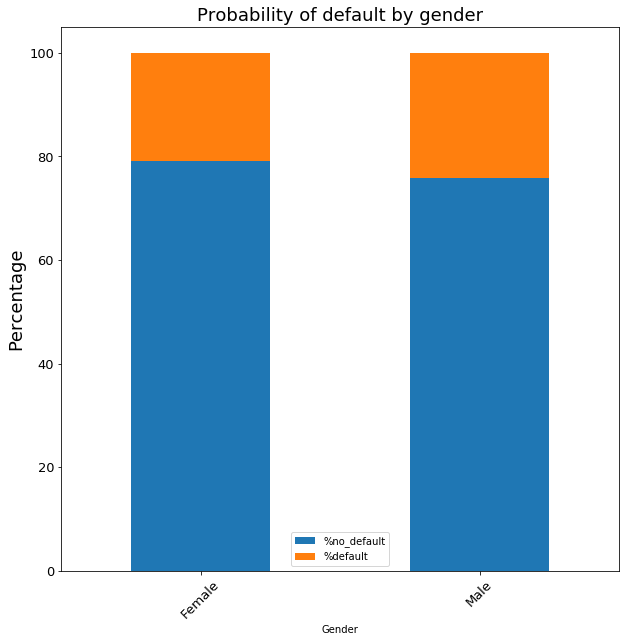

In [29]:
ax=df_sex.plot(figsize=(10,10),kind='bar',x='Gender', stacked=True, fontsize=13)
ax.set_title("Probability of default by gender", fontsize=18)
ax.set_ylabel("Percentage", fontsize=18)
ax.set_xticklabels(rotation=45, labels=df_sex['Gender'].to_list())
plt.savefig("gender_proba.png", transparent=True)

# Relationships status

In [30]:
df1['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

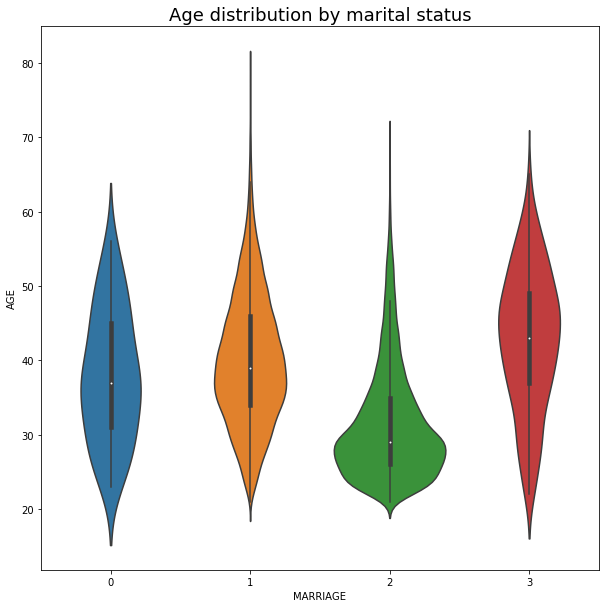

In [31]:
plt.figure(figsize=(10,10))
ax=sns.violinplot(data=df1, x='MARRIAGE',y='AGE')
ax.set_title("Age distribution by marital status", fontsize=18)
plt.savefig("marriage_age.png", transparent=True)

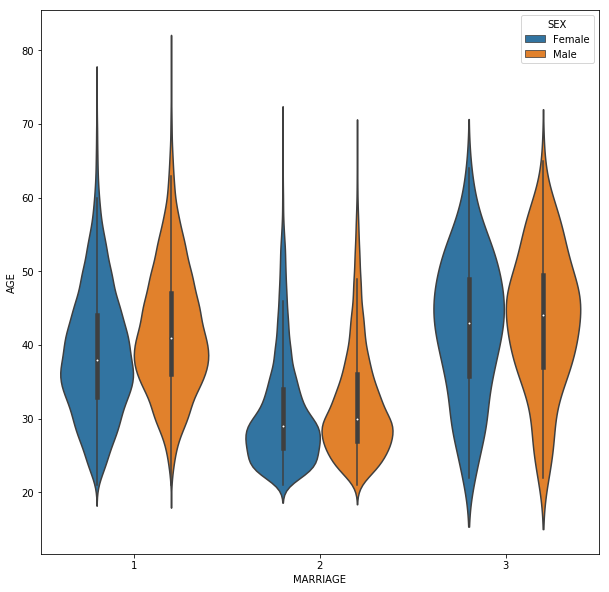

In [32]:
plt.figure(figsize=(10,10))
sns.violinplot(data=df1[df1['MARRIAGE']!=0], x='MARRIAGE',y='AGE', hue='SEX')

Men tend to stay single for longer and get married at an older age

In [33]:
relation={0:'Others',1:'Married',2:'Single',3:'Divorced'}
for i in relation:
    df1.loc[df1['MARRIAGE']==i, 'MARRIAGE']=relation[i]

In [34]:
df_marital=pd.DataFrame(df1['MARRIAGE'].loc[df1['default_next_month'] == 0].value_counts())
df_marital.columns=['no_default']
df_marital['default']=df1['MARRIAGE'].loc[df1['default_next_month'] == 1].value_counts()
df_marital['Total']=df1['MARRIAGE'].value_counts()
df_marital['%no_default']=(df_marital['no_default']/df_marital['Total'])*100
df_marital['%default']=(df_marital['default']/df_marital['Total'])*100
df_marital=df_marital.rename_axis('Marital status').reset_index()
df_marital=df_marital.drop(['no_default','default','Total'],axis=1)
df_marital

,Marital status,%no_default,%default
0,Single,79.071661,20.928339
1,Married,76.528296,23.471704
2,Divorced,73.993808,26.006192
3,Others,90.740741,9.259259


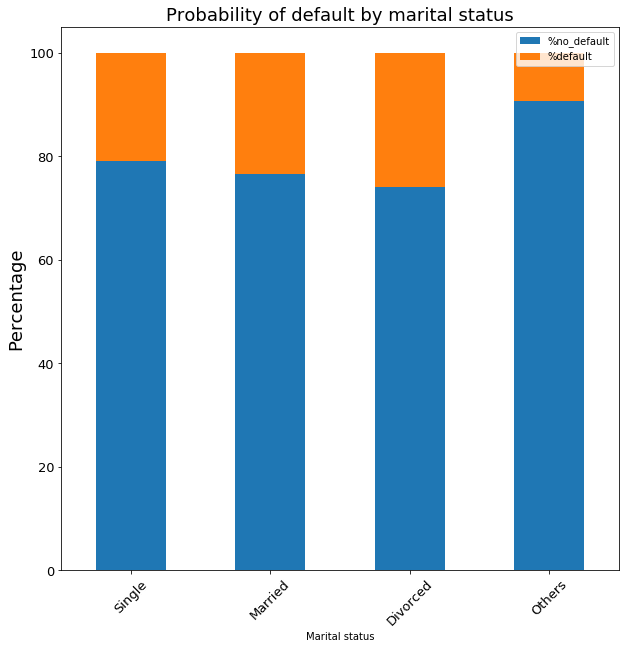

In [35]:
ax=df_marital.plot(figsize=(10,10),kind='bar',x='Marital status', stacked=True, fontsize=13)
ax.set_title("Probability of default by marital status", fontsize=18)
ax.set_ylabel("Percentage", fontsize=18)
ax.set_xticklabels(rotation=45, labels=df_marital['Marital status'].to_list())
plt.savefig("marriage_proba.png",transparent=True)

# Bill amount

In [36]:
df.BILL_AMT1.max()

964511

In [37]:
df.LIMIT_BAL.max()

1000000

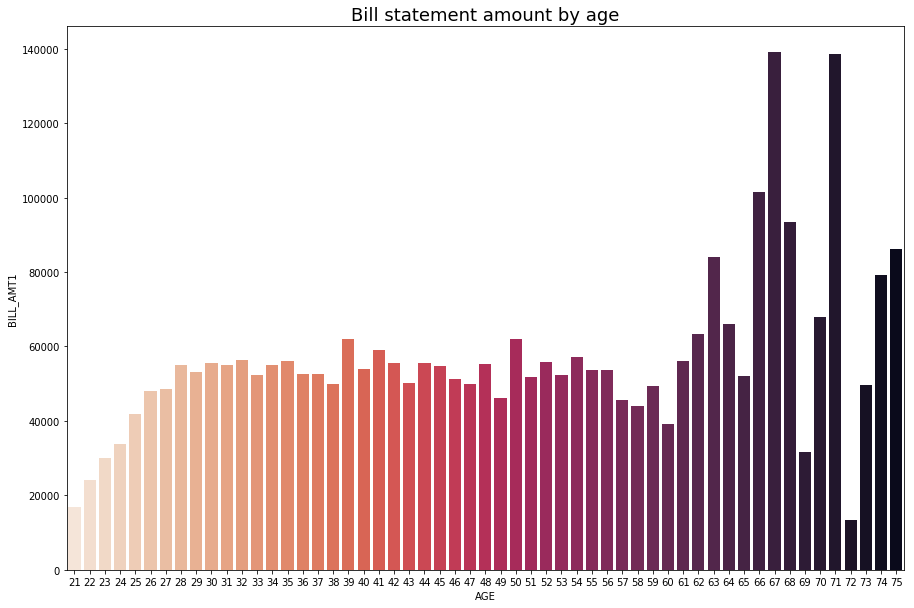

In [38]:
a=pd.DataFrame(df[df['AGE']!=79].groupby('AGE').mean().BILL_AMT1).reset_index()
plt.figure(figsize=(15,10))
sns.barplot(data=a,x='AGE',y='BILL_AMT1', palette='rocket_r')
plt.title("Bill statement amount by age", fontsize=18)
plt.savefig("BILL.png",transparent=True)

In [39]:
df.BILL_AMT1.value_counts().count()

22723

In [40]:
df[df['AGE']>=75][['AGE','BILL_AMT1']]

,AGE,BILL_AMT1
246,75,52874
18245,79,429309
25136,75,0
25141,75,205601


In [41]:
df[(df['BILL_AMT1']<0)].shape

(590, 24)

In [42]:
df[(df['BILL_AMT1']<0)&(df['default_next_month']==1)].shape

(109, 24)

# PAY_AMT

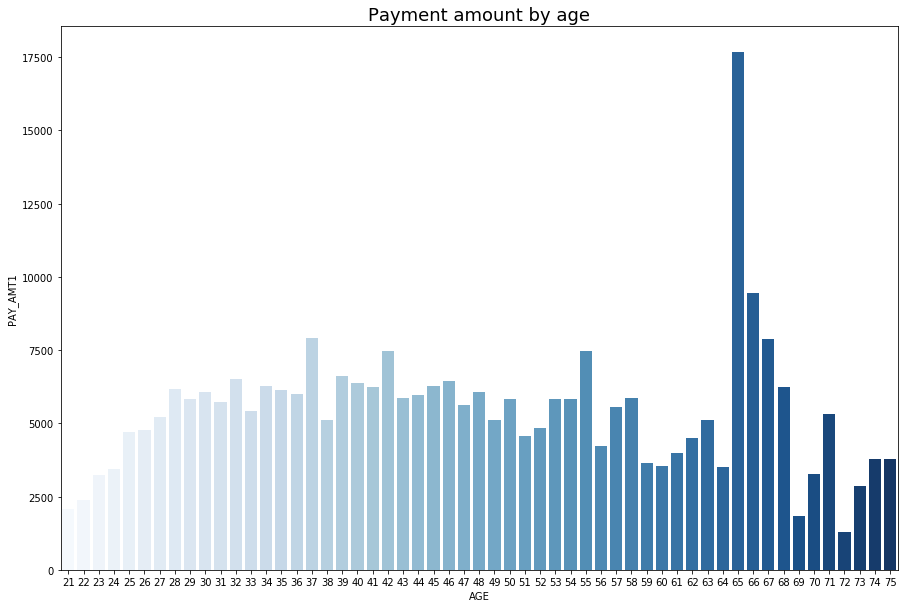

In [43]:
b=pd.DataFrame(df[df['AGE']!=79].groupby('AGE').mean().PAY_AMT1).reset_index()
plt.figure(figsize=(15,10))
sns.barplot(data=b,x='AGE',y='PAY_AMT1', palette='Blues')
plt.title("Payment amount by age", fontsize=18)
plt.savefig("PAY.png",transparent=True)

In [44]:
df[(df['PAY_AMT1']>df['BILL_AMT2'])].shape

(3464, 24)

In [45]:
#This shows that multiple clients (417) overpaid last month's bill and still defaulted
df[(df['PAY_AMT1']>df['BILL_AMT2'])&(df['default_next_month']==1)].shape

(417, 24)

In [46]:
# 620 out of the 2500 with negative bill amounts overpaid, therefore the negative bill amounts are not explained by this
df[(df['PAY_AMT1']>df['BILL_AMT2'])&(df['BILL_AMT1']<0)].shape

(588, 24)

In [47]:
df[(df['PAY_AMT1']>df['BILL_AMT2'])&(df['BILL_AMT1']<0)&(df['default_next_month']==1)].shape

(108, 24)

In [48]:
df[(df['BILL_AMT1']<=0)&(df['default_next_month']==1)].shape

(643, 24)

# Credit Limit

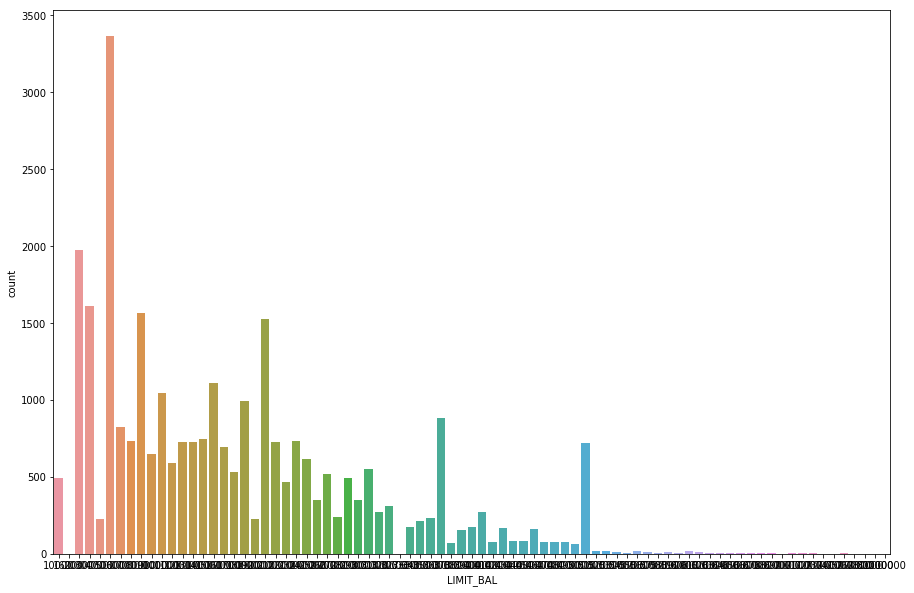

In [49]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=df.sort_values(by=['LIMIT_BAL'],ascending=False),x='LIMIT_BAL')

In [50]:
df[df['LIMIT_BAL']!=0].LIMIT_BAL.mode()

0    50000
dtype: int64

In [51]:
df_lim=pd.DataFrame(df1['LIMIT_BAL'].loc[df1['default_next_month'] == 0].value_counts())
df_lim.columns=['no_default']
df_lim['default']=df1['LIMIT_BAL'].loc[df1['default_next_month'] == 1].value_counts()
df_lim['Total']=df1['LIMIT_BAL'].value_counts()
df_lim['%no_default']=(df_lim['no_default']/df_lim['Total'])*100
df_lim['%default']=(df_lim['default']/df_lim['Total'])*100
df_lim=df_lim.rename_axis('Credit Limit').reset_index()
df_lim=df_lim.drop(['no_default','default','Total'],axis=1)
df_lim=df_lim.sort_values(by=['Credit Limit'],ascending=False)

[Text(0,0,'1000000'),
 Text(0,0,'800000'),
 Text(0,0,'780000'),
 Text(0,0,'760000'),
 Text(0,0,'750000'),
 Text(0,0,'740000'),
 Text(0,0,'730000'),
 Text(0,0,'720000'),
 Text(0,0,'710000'),
 Text(0,0,'700000'),
 Text(0,0,'690000'),
 Text(0,0,'680000'),
 Text(0,0,'670000'),
 Text(0,0,'660000'),
 Text(0,0,'650000'),
 Text(0,0,'640000'),
 Text(0,0,'630000'),
 Text(0,0,'620000'),
 Text(0,0,'610000'),
 Text(0,0,'600000'),
 Text(0,0,'590000'),
 Text(0,0,'580000'),
 Text(0,0,'570000'),
 Text(0,0,'560000'),
 Text(0,0,'550000'),
 Text(0,0,'540000'),
 Text(0,0,'530000'),
 Text(0,0,'520000'),
 Text(0,0,'510000'),
 Text(0,0,'500000'),
 Text(0,0,'490000'),
 Text(0,0,'480000'),
 Text(0,0,'470000'),
 Text(0,0,'460000'),
 Text(0,0,'450000'),
 Text(0,0,'440000'),
 Text(0,0,'430000'),
 Text(0,0,'420000'),
 Text(0,0,'410000'),
 Text(0,0,'400000'),
 Text(0,0,'390000'),
 Text(0,0,'380000'),
 Text(0,0,'370000'),
 Text(0,0,'360000'),
 Text(0,0,'350000'),
 Text(0,0,'340000'),
 Text(0,0,'330000'),
 Text(0,0,'3

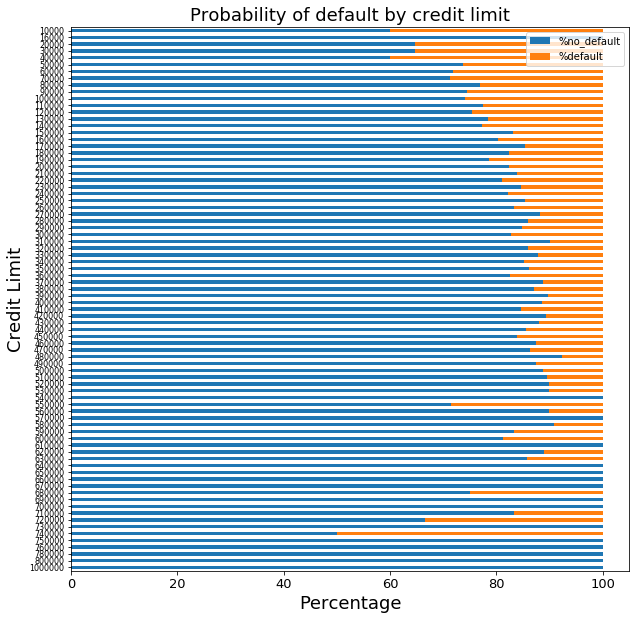

In [52]:
ax=df_lim.plot(figsize=(10,10),kind='barh',x='Credit Limit', stacked=True, fontsize=13)
ax.set_title("Probability of default by credit limit", fontsize=18)
ax.set_ylabel("Credit Limit", fontsize=18)
ax.set_xlabel("Percentage", fontsize=18)
ax.set_yticklabels(labels=df_lim['Credit Limit'],fontsize=8)

In [53]:
L=[]
for i in list(range(1,7)):
    x='%REMAINING_BAL'+str(i)
    L.append(x)
    y='BILL_AMT'+str(i)
    df[x]=(df['LIMIT_BAL']-df[y])/df['LIMIT_BAL']

In [54]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month,%REMAINING_BAL1,%REMAINING_BAL2,%REMAINING_BAL3,%REMAINING_BAL4,%REMAINING_BAL5,%REMAINING_BAL6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0.804350,0.844900,0.965550,1.000000,1.000000,1.000000
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0.977650,0.985625,0.977650,0.972733,0.971208,0.972825
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.675122,0.844144,0.849344,0.840767,0.833911,0.827233
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.060200,0.035340,0.014180,0.433720,0.420820,0.409060
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0.827660,0.886600,0.283300,0.581200,0.617080,0.617380


In [55]:
df[df['default_next_month']==1][L].mean()

%REMAINING_BAL1    0.509703
%REMAINING_BAL2    0.513693
%REMAINING_BAL3    0.530518
%REMAINING_BAL4    0.560302
%REMAINING_BAL5    0.588519
%REMAINING_BAL6    0.601481
dtype: float64

In [56]:
df[df['default_next_month']==0][L].mean()

%REMAINING_BAL1    0.595124
%REMAINING_BAL2    0.610225
%REMAINING_BAL3    0.629760
%REMAINING_BAL4    0.663275
%REMAINING_BAL5    0.689152
%REMAINING_BAL6    0.704118
dtype: float64

In [57]:
df_rem=pd.DataFrame(df[df['default_next_month']==0][L].mean())
df_rem.columns=['no_default']
df_rem['default']=df[df['default_next_month']==1][L].mean()
df_rem=df_rem.rename_axis('Remaining credit limit').reset_index()
df_rem

,Remaining credit limit,no_default,default
0,%REMAINING_BAL1,0.595124,0.509703
1,%REMAINING_BAL2,0.610225,0.513693
2,%REMAINING_BAL3,0.629760,0.530518
3,%REMAINING_BAL4,0.663275,0.560302
4,%REMAINING_BAL5,0.689152,0.588519
5,%REMAINING_BAL6,0.704118,0.601481


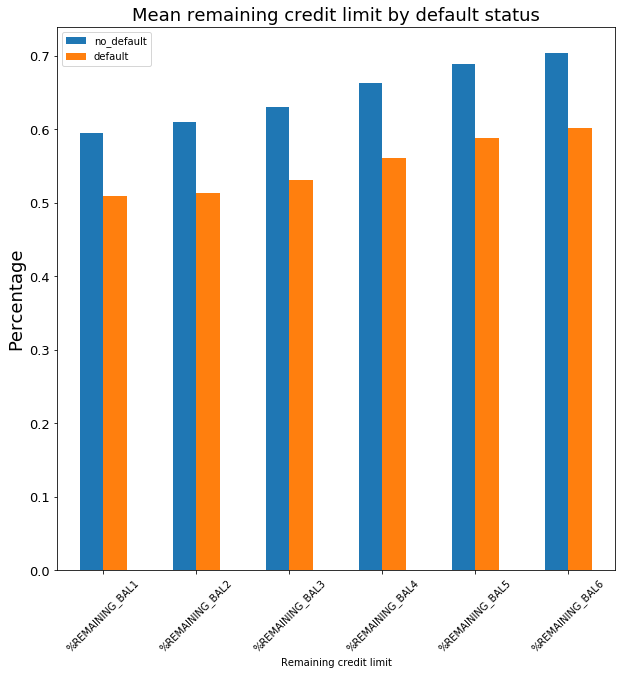

In [58]:
ax=df_rem.plot(figsize=(10,10),kind='bar',x='Remaining credit limit', stacked=False, fontsize=13)
ax.set_title("Mean remaining credit limit by default status", fontsize=18)
ax.set_ylabel("Percentage", fontsize=18)
ax.set_xticklabels(labels=df_rem['Remaining credit limit'],fontsize=10, rotation=45)
plt.savefig("rem_credit.png",transparent=True)

In [59]:
print(df['%REMAINING_BAL1'].min())
print(df['%REMAINING_BAL1'].max())
print(df['%REMAINING_BAL1'].mean())

-5.4553
1.619892
0.5762285486750798


### Negative Bill Amount

In [60]:
print(df[(df['%REMAINING_BAL1']>1)].shape)
print(df[(df['%REMAINING_BAL1']>1)&(df['default_next_month']==1)].shape)

(590, 30)
(109, 30)


In [61]:
df[(df['BILL_AMT1']<0)].shape

(590, 30)

### Exceeded credit limit

In [62]:
print(df[(df['%REMAINING_BAL1']<0)].shape)
print(df[(df['%REMAINING_BAL1']<0)&(df['default_next_month']==0)].shape)

(2115, 30)
(1479, 30)


In [63]:
#37 clients used more than twice of their credit limit
df[(df['%REMAINING_BAL1']<-1)]['%REMAINING_BAL1'].shape

(37,)

In [64]:
print(str(100*(2115/len(df)))+'% of all clients exceeded their credit limit in September')

7.049999999999999% of all clients exceeded their credit limit in September


# Bill Amt & Pay Amt

In [65]:
#L2=[]
#for i in list(range(1,7)):
    #x='%BILL_PAID'+str(i)
    #z='PAY_AMT'+str(i)
    #L2.append(x)
    #y='BILL_AMT'+str(i)
    #df[x]=(df[z])/df[y]

df[L2].fillna(0)

# Repayment status

In [66]:
df['PAY_1'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

In [67]:
# For consistency and since -1 and -2 have the same default probability as 0, they are regrouped under it
for i in list(range(1,7)):
    x='PAY_'+str(i)
    df.loc[df[x]==-1,x]=0
    df.loc[df[x]==-2,x]=0

In [68]:
df_pay=pd.DataFrame(df['PAY_1'].loc[df['default_next_month'] == 0].value_counts())
df_pay.columns=['no_default']
df_pay['default']=df['PAY_1'].loc[df1['default_next_month'] == 1].value_counts()
df_pay['Total']=df['PAY_1'].value_counts()
df_pay['%no_default']=(df_pay['no_default']/df_pay['Total'])*100
df_pay['%default']=(df_pay['default']/df_pay['Total'])*100
df_pay=df_pay.rename_axis('PAY_1').reset_index()
df_pay=df_pay.drop(['no_default','default','Total'],axis=1)
df_pay=df_pay.fillna(0)
df_pay=df_pay.sort_values(by=['PAY_1'],ascending=False)

In [69]:
df_pay

,PAY_1,%no_default,%default
6,8,42.105263,57.894737
8,7,22.222222,77.777778
7,6,45.454545,54.545455
5,5,50.000000,50.000000
4,4,31.578947,68.421053
3,3,24.223602,75.776398
2,2,30.858643,69.141357
1,1,66.052061,33.947939
0,0,86.165991,13.834009


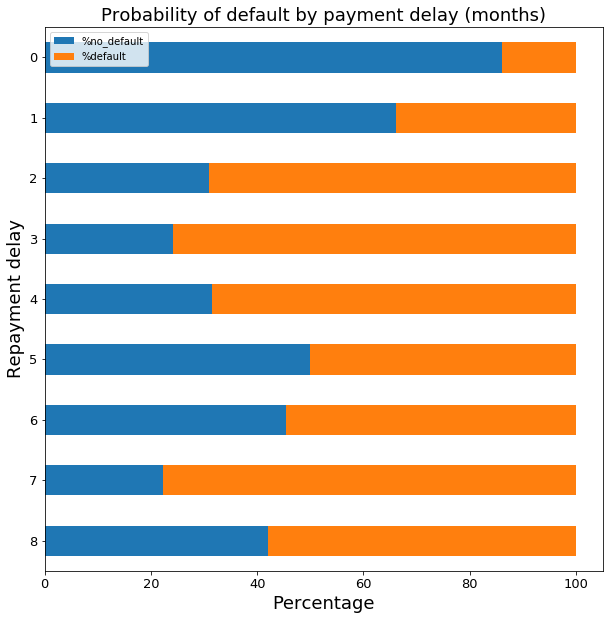

In [70]:
ax=df_pay.plot(figsize=(10,10),kind='barh',x='PAY_1', stacked=True, fontsize=13)
ax.set_title("Probability of default by payment delay (months)", fontsize=18)
ax.set_ylabel("Repayment delay", fontsize=18)
ax.set_xlabel("Percentage", fontsize=18)
plt.savefig("PAY_proba.png", transparent=True)

# Correlations 2

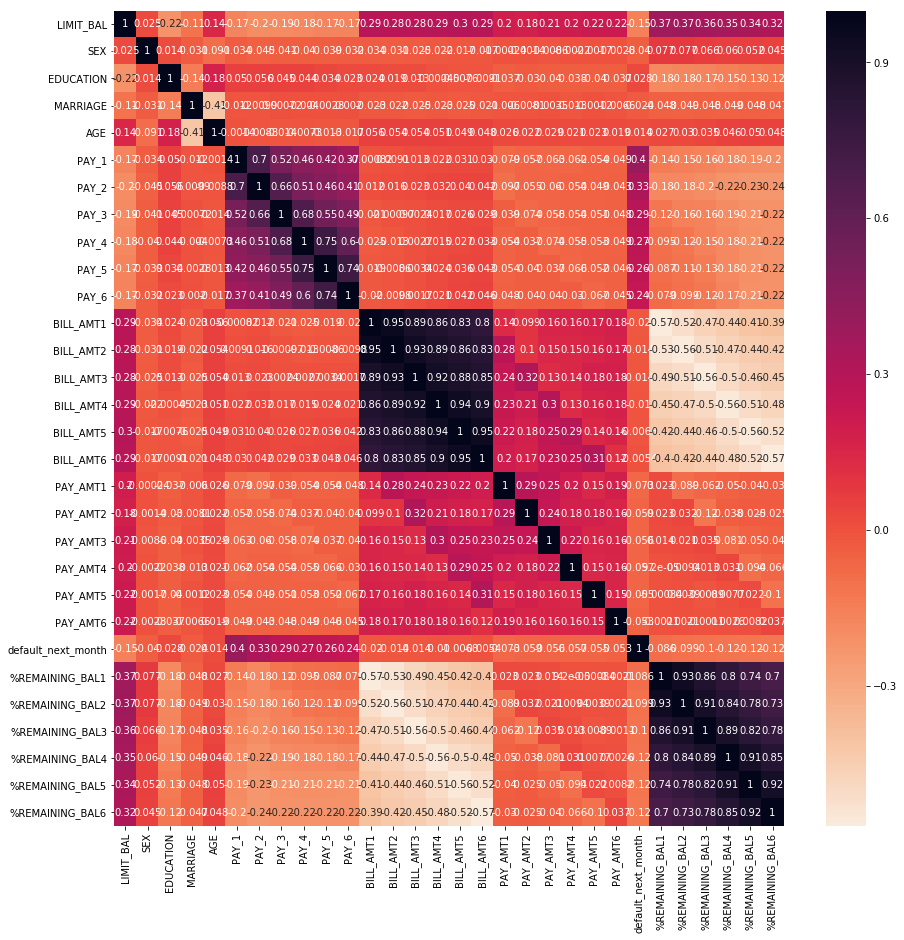

In [71]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap='rocket_r', annot=True)

# Default prediction

In [72]:
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, roc_curve, f1_score

In [73]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline

In [74]:
from sklearn.metrics import classification_report

# Splitting

In [242]:
X= df.drop('default_next_month',1)
X=X.loc[X['AGE']!=79]
y= df.loc[df['AGE']!=79]['default_next_month']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=37, stratify=y)

In [243]:
X_xgb=X.copy()
xgb_col=[]
for i in X.columns.to_list():
    f ='f'+str(len(xgb_col))
    xgb_col.append(f)

In [244]:
X_xgb.columns=xgb_col
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb,y,test_size=0.2, random_state=37, stratify=y)

# Informative Models

# Blind decision tree

In [79]:
Tree = DecisionTreeClassifier(random_state=37)

In [80]:
Tree.fit(X=X_train,y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=37,
            splitter='best')

In [81]:
accuracy_score(y_pred=Tree.predict(X=X_test),y_true=y_test)

0.7261666666666666

In [82]:
roc_auc_score(y_score=Tree.predict_proba(X=X_test)[:, 1],y_true=y_test)

0.6081756683643842

In [83]:
feat_imp=pd.DataFrame(Tree.feature_importances_)
feat_imp=feat_imp.transpose()
feat_imp.columns=X.columns
feat_imp

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,%REMAINING_BAL1,%REMAINING_BAL2,%REMAINING_BAL3,%REMAINING_BAL4,%REMAINING_BAL5,%REMAINING_BAL6
0,0.038103,0.009975,0.019029,0.013256,0.059917,0.157035,0.030908,0.010225,0.002828,0.007356,0.005363,0.039875,0.026066,0.030081,0.028844,0.031453,0.035334,0.037302,0.036273,0.047803,0.039671,0.034261,0.040905,0.043829,0.040211,0.031328,0.036714,0.033468,0.032589


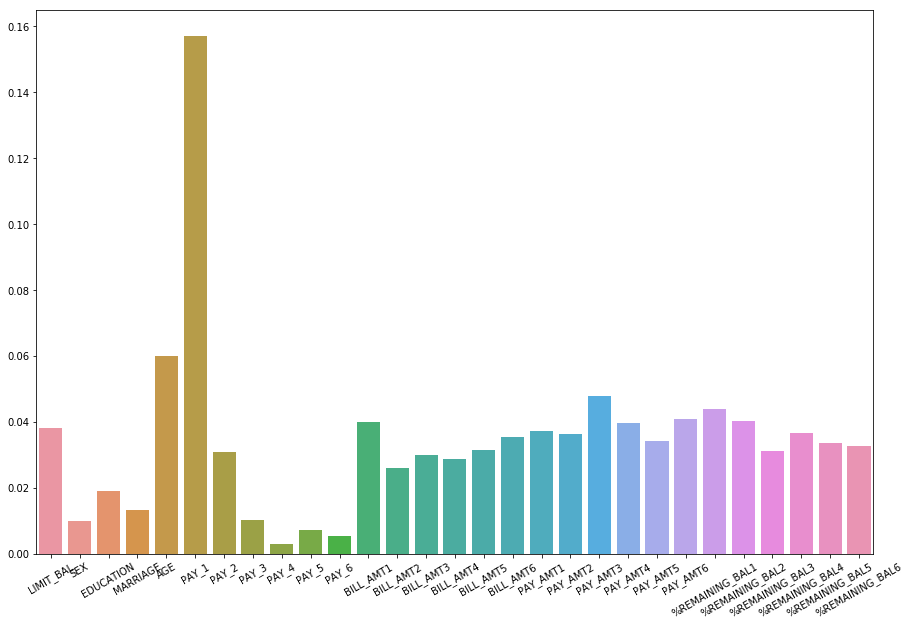

In [84]:
plt.figure(figsize=(15,10))
g=sns.barplot(data=feat_imp)
g.set_xticklabels(rotation=30, labels=X.columns)
plt.savefig("tree_feature.png",transparent=True)

# Lasso

In [85]:
lassocv = LassoCV(cv=5, alphas=[0.5,0.2,0.1,0.01,0.001], n_jobs=-1)

In [86]:
lassocv.fit(X_train,y_train)

LassoCV(alphas=[0.5, 0.2, 0.1, 0.01, 0.001], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=-1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [87]:
lassocv.alpha_

0.001

In [88]:
lassocv.coef_

array([-2.42001324e-07, -1.69869432e-02, -9.46311190e-03, -1.63681614e-02,
        1.06779430e-03,  1.58910454e-01,  1.50020679e-02,  2.63486208e-02,
        1.08218502e-02,  1.45856136e-02,  2.28895185e-02, -1.50335041e-07,
        2.34836304e-07,  8.18631842e-08, -2.39381834e-08, -2.43068754e-07,
        2.22341599e-07, -6.84554447e-07, -1.42442224e-07, -2.77403497e-08,
       -1.92873797e-07, -4.04516965e-07, -2.01023989e-07,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00])

In [365]:
X.columns[np.where(lassocv.coef_ > 0.0000000001)[0].tolist()]

Index(['AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT6'],
      dtype='object')

# Informative Random Forest

[Text(0,0,'LIMIT_BAL'),
 Text(0,0,'SEX'),
 Text(0,0,'EDUCATION'),
 Text(0,0,'MARRIAGE'),
 Text(0,0,'AGE'),
 Text(0,0,'PAY_1'),
 Text(0,0,'PAY_2'),
 Text(0,0,'PAY_3'),
 Text(0,0,'PAY_4'),
 Text(0,0,'PAY_5'),
 Text(0,0,'PAY_6'),
 Text(0,0,'BILL_AMT1'),
 Text(0,0,'BILL_AMT2'),
 Text(0,0,'BILL_AMT3'),
 Text(0,0,'BILL_AMT4'),
 Text(0,0,'BILL_AMT5'),
 Text(0,0,'BILL_AMT6'),
 Text(0,0,'PAY_AMT1'),
 Text(0,0,'PAY_AMT2'),
 Text(0,0,'PAY_AMT3'),
 Text(0,0,'PAY_AMT4'),
 Text(0,0,'PAY_AMT5'),
 Text(0,0,'PAY_AMT6'),
 Text(0,0,'%REMAINING_BAL1'),
 Text(0,0,'%REMAINING_BAL2'),
 Text(0,0,'%REMAINING_BAL3'),
 Text(0,0,'%REMAINING_BAL4'),
 Text(0,0,'%REMAINING_BAL5'),
 Text(0,0,'%REMAINING_BAL6')]

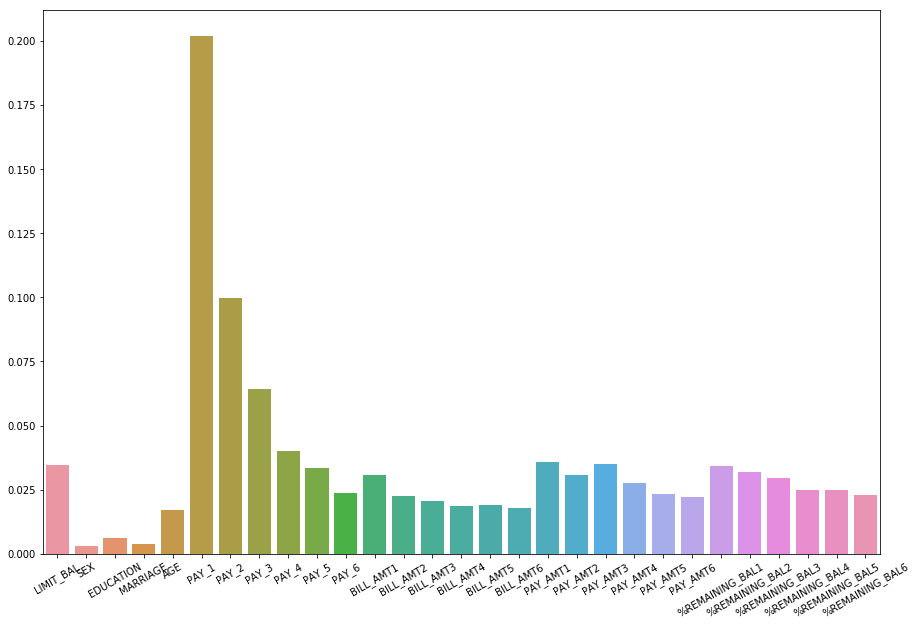

In [366]:
RF2=RandomForestClassifier(n_jobs=-1, random_state=37, class_weight='balanced', max_depth=10,max_features=5,n_estimators=150)
RF2_clf=RF2.fit(X_train, y_train)

RD_feat=pd.DataFrame(RF2.feature_importances_).transpose()
RD_feat.columns=X.columns
plt.figure(figsize=(15,10))
g=sns.barplot(data=RD_feat)
g.set_xticklabels(rotation=30, labels=X.columns)

# Predictive Modelling

# No sampling - Logistic 

In [93]:
logit=LogisticRegression(random_state=37, solver = "liblinear", max_iter=200)
parameters_logit = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20)}
grid_logit = GridSearchCV(logit, param_grid=parameters_logit, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [94]:
logit_clf=grid_logit.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.7min finished


In [95]:
print('The optimal parameters for the RF are:', logit_clf.best_params_, 'with a validation ROC auc score of:', logit_clf.best_score_)

The optimal parameters for the RF are: {'C': 0.08858667904100823, 'penalty': 'l1'} with a validation ROC auc score of: 0.7589429617192803


In [96]:
roc_auc_score(y_score=logit_clf.predict_proba(X_test)[:, 1], y_true=y_test)

0.7520789553933506

# SMOTE - Logistic 

In [97]:
pipeline_logit = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('logit', LogisticRegression(random_state=37, solver = "liblinear"))])
parameters_logit_res = {'logit__penalty' : ['l1', 'l2'], 'logit__C' : np.logspace(-4, 4, 20)}
grid_logit_res = GridSearchCV(pipeline_logit, param_grid=parameters_logit_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [98]:
logit_res=grid_logit_res.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  3.7min finished


In [99]:
print('The optimal parameters for the RF are:', logit_res.best_params_, 'with a validation ROC auc score of:', logit_res.best_score_)

The optimal parameters for the RF are: {'logit__C': 0.012742749857031334, 'logit__penalty': 'l1'} with a validation ROC auc score of: 0.761565474741622


In [100]:
roc_auc_score(y_score=logit_res.predict_proba(X_test)[:, 1], y_true=y_test)

0.7550642461600585

## Borderline SMOTE - Logit

In [101]:
pipeline_logit2 = Pipeline([('B_SMOTE',BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('logit', LogisticRegression(random_state=37, solver = "liblinear"))])
parameters_logit_res = {'logit__penalty' : ['l1', 'l2'], 'logit__C' : np.logspace(-4, 4, 20)}
grid_logit_res2 = GridSearchCV(pipeline_logit2, param_grid=parameters_logit_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [102]:
logit_res2=grid_logit_res2.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  4.0min finished


# No sampling - RF

In [359]:
X_train.shape

(23999, 29)

In [104]:
RF=RandomForestClassifier(n_jobs=-2, random_state=37)
parameteres_RF = {'n_estimators' : list(range(100,151,10)), 'max_features' : list(range(1,11,2)), 'class_weight' : [None, 'balanced'], 'max_depth': [15, 10 , 5]}
grid_RF = GridSearchCV(RF, param_grid=parameteres_RF, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [105]:
RF_clf=grid_RF.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed: 14.2min finished


In [106]:
print('The optimal parameters for the RF are:', RF_clf.best_params_, 'with a validation ROC auc score of:', RF_clf.best_score_)

The optimal parameters for the RF are: {'class_weight': None, 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} with a validation ROC auc score of: 0.7823416581420589


In [107]:
RF_Pscore=RF_clf.predict_proba(X_test)
roc_auc_score(y_score=RF_Pscore[:, 1], y_true=y_test)

0.7834404734278966

# SMOTE - RF

In [111]:
sm = SMOTE(random_state = 37, k_neighbors=10)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [112]:
pipeline_RF = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('RF', RandomForestClassifier(n_jobs=-1, random_state=37))])
parameteres_RF = {'RF__n_estimators' : list(range(100,151,10)), 'RF__max_features' : list(range(1,11,2)), 'RF__max_depth': [15, 10 , 5]}
grid_RF_res = GridSearchCV(pipeline_RF, param_grid=parameteres_RF, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [113]:
RF_res=grid_RF_res.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 12.3min finished


In [114]:
print('The optimal parameters for the RF are:', RF_res.best_params_, 'with a validation ROC auc score of:', RF_res.best_score_)

The optimal parameters for the RF are: {'RF__max_depth': 10, 'RF__max_features': 7, 'RF__n_estimators': 150} with a validation ROC auc score of: 0.7790893556504329


In [115]:
roc_auc_score(y_score=RF_res.predict_proba(X_test)[:, 1], y_true=y_test)

0.7760175621275744

## Borderline SMOTE - RF

In [116]:
pipeline_RF2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('RF', RandomForestClassifier(n_jobs=-1, random_state=37))])
parameteres_RF = {'RF__n_estimators' : list(range(100,151,10)), 'RF__max_features' : list(range(1,11,2)), 'RF__max_depth': [15, 10 , 5]}
grid_RF_res2 = GridSearchCV(pipeline_RF2, param_grid=parameteres_RF, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [117]:
RF_res2=grid_RF_res2.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 13.2min finished


# ANN

In [367]:
'''Sklearn is used instead of Keras for reproducibility'''

'Sklearn is used instead of Keras for reproducibility'

In [118]:
NN=MLPClassifier(random_state=37, solver='adam', batch_size=100)
parameteres_NN = {'hidden_layer_sizes' : [(100,100,100),(300,300), (300,), (200,), (500,)]}
grid_NN = GridSearchCV(NN, param_grid=parameteres_NN, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [119]:
NN_clf=grid_NN.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.9min finished


In [120]:
print('The optimal parameters for the NN are:', NN_clf.best_params_, 'with a validation ROC auc score of:', NN_clf.best_score_)

The optimal parameters for the NN are: {'hidden_layer_sizes': (300,)} with a validation ROC auc score of: 0.6558275599077256


In [121]:
roc_auc_score(y_score=NN_clf.predict_proba(X_test)[:, 1], y_true=y_test)

0.6005809319067626

# SMOTE - ANN

In [122]:
pipeline_NN = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('NN', MLPClassifier(random_state=37, solver='adam', batch_size=100))])
parameteres_NN_res = {'NN__hidden_layer_sizes' : [(500,), (300,300), (300,), (600,)]}
grid_NN_res = GridSearchCV(pipeline_NN, param_grid=parameteres_NN_res, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [123]:
NN_clf_res=grid_NN_res.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.5min finished


In [124]:
print('The optimal parameters for the NN are:', NN_clf_res.best_params_, 'with a validation ROC auc score of:', NN_clf_res.best_score_)

The optimal parameters for the NN are: {'NN__hidden_layer_sizes': (500,)} with a validation ROC auc score of: 0.6427089671447399


In [125]:
roc_auc_score(y_score=NN_clf_res.predict_proba(X_test)[:, 1], y_true=y_test)

0.6046128160764488

## Borderline SMOTE - ANN

In [126]:
pipeline_NN2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('NN', MLPClassifier(random_state=37, solver='adam', batch_size=100))])
parameteres_NN_res = {'NN__hidden_layer_sizes' : [(500,), (300,300), (300,), (500,500), (600,600), (600,)], 'NN__max_iter' : [50,100,200]}
grid_NN_res2 = GridSearchCV(pipeline_NN2, param_grid=parameteres_NN_res, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [127]:
NN_clf_res2=grid_NN_res2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 167.3min finished


# No sampling - XGBoost

In [128]:
XGB=XGBClassifier(n_jobs=-1, random_state=37)
parameteres_XGB = {'n_estimators' : list(range(100,151,10))}
grid_XGB = GridSearchCV(XGB, param_grid=parameteres_XGB, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [129]:
XGB_clf=grid_XGB.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
D:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
D:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.9min finished


In [130]:
print('The optimal parameters for the NN are:', XGB_clf.best_params_, 'with a validation ROC auc score of:', XGB_clf.best_score_)

The optimal parameters for the NN are: {'max_depth': 5, 'n_estimators': 100} with a validation ROC auc score of: 0.7828275934284988


In [131]:
roc_auc_score(y_score=XGB_clf.predict_proba(X_test)[:, 1], y_true=y_test)

0.7781055079033927

# SMOTE - XGBoost

In [132]:
pipeline_XGB = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('XGB', XGBClassifier(n_jobs=-1, random_state=37))])
parameteres_XGB_res = {'XGB__n_estimators' : list(range(100,151,10))}
grid_XGB_res = GridSearchCV(pipeline_XGB, param_grid=parameteres_XGB_res, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [133]:
XGB_clf_res=grid_XGB_res.fit(X_xgb_train,y_xgb_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.9min finished


In [134]:
print('The optimal parameters for the NN are:', XGB_clf_res.best_params_, 'with a validation ROC auc score of:', XGB_clf_res.best_score_)

The optimal parameters for the NN are: {'XGB__max_depth': 3, 'XGB__n_estimators': 150} with a validation ROC auc score of: 0.7803199691575697


In [135]:
roc_auc_score(y_score=XGB_clf_res.predict_proba(X_xgb_test)[:, 1], y_true=y_test)

0.7774543300665321

## Borderline SMOTE - XGBoost

In [136]:
pipeline_XGB2 = Pipeline([('SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('XGB', XGBClassifier(n_jobs=-1, random_state=37))])
parameteres_XGB_res = {'XGB__n_estimators' : list(range(100,151,10))}
grid_XGB_res2 = GridSearchCV(pipeline_XGB2, param_grid=parameteres_XGB_res, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [137]:
XGB_clf_res2=grid_XGB_res2.fit(X_xgb_train,y_xgb_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.6min finished


# REDUCED MODEL

In [370]:
X_red=X[['PAY_1','PAY_AMT1','PAY_AMT2','PAY_AMT3','%REMAINING_BAL1','%REMAINING_BAL2','%REMAINING_BAL3']]

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red,y,test_size=0.2, random_state=37, stratify=y)

X_xgb_red=X_red.copy()
xgb_col2=[]
for i in X_red.columns.to_list():
    f ='f'+str(len(xgb_col2))
    xgb_col2.append(f)

X_xgb_red.columns=xgb_col2
X_xgb_red_train, X_xgb_red_test, y_xgb_red_train, y_xgb_red_test = train_test_split(X_xgb_red,y,test_size=0.2, random_state=37, stratify=y)

# No Sampling - Reduced - logit

In [371]:
logit=LogisticRegression(random_state=37, solver = "liblinear", max_iter=200)
parameters_logit = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20)}
grid_logit = GridSearchCV(logit, param_grid=parameters_logit, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [372]:
logit_red=grid_logit.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:   27.7s finished


In [373]:
print('The optimal parameters for the RF are:', logit_red.best_params_, 'with a validation ROC auc score of:', logit_red.best_score_)

The optimal parameters for the RF are: {'C': 0.0018329807108324356, 'penalty': 'l1'} with a validation ROC auc score of: 0.7473242005607136


In [374]:
roc_auc_score(y_score=logit_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7442825602222584

# SMOTE - Reduced - logit

In [375]:
pipeline_logit = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('logit', LogisticRegression(random_state=37, solver = "liblinear"))])
parameters_logit_res = {'logit__penalty' : ['l1', 'l2'], 'logit__C' : np.logspace(-4, 4, 20)}
grid_logit_res = GridSearchCV(pipeline_logit, param_grid=parameters_logit_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [376]:
logit_res_red=grid_logit_res.fit(X_red_train, y_red_train)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:   22.3s finished


In [377]:
print('The optimal parameters for the RF are:', logit_res_red.best_params_, 'with a validation ROC auc score of:', logit_res_red.best_score_)

The optimal parameters for the RF are: {'logit__C': 0.0001, 'logit__penalty': 'l2'} with a validation ROC auc score of: 0.7456832371121671


In [378]:
roc_auc_score(y_score=logit_res_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7399532274344223

## Borderline SMOTE - Reduced - logit

In [379]:
pipeline_logit2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('logit', LogisticRegression(random_state=37, solver = "liblinear"))])
parameters_logit_res = {'logit__penalty' : ['l1', 'l2'], 'logit__C' : np.logspace(-4, 4, 20)}
grid_logit_res2 = GridSearchCV(pipeline_logit2, param_grid=parameters_logit_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [380]:
logit_res_red2=grid_logit_res2.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:   27.9s finished


# No Sampling - Reduced - RF

In [381]:
X_red_train.shape

(23999, 7)

In [382]:
list(range(1,8,1))

[1, 2, 3, 4, 5, 6, 7]

In [383]:
RF_red=RandomForestClassifier(n_jobs=-1, random_state=37)
parameteres_RF_red = {'n_estimators' : list(range(100,151,10)), 'max_features' : list(range(1,8,1)), 'class_weight' : [None, 'balanced'], 'max_depth': [15, 10 , 5]}
grid_RF_red = GridSearchCV(RF_red, param_grid=parameteres_RF_red, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc')

In [384]:
RF_clf_red=grid_RF_red.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 20.2min finished


In [385]:
print('The optimal parameters for the RF are:', RF_clf_red.best_params_, 'with a validation ROC auc score of:', RF_clf_red.best_score_)

The optimal parameters for the RF are: {'class_weight': None, 'max_depth': 10, 'max_features': 2, 'n_estimators': 130} with a validation ROC auc score of: 0.7737793197182686


In [386]:
roc_auc_score(y_score=RF_clf_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7642910394027096

# SMOTE - Reduced - RF

In [429]:
pipeline_RF_red = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('RF', RandomForestClassifier(n_jobs=-1, random_state=37))])
parameteres_RF_res_red = {'RF__n_estimators' : list(range(100,151,10)), 'RF__max_features' : list(range(1,8,1)), 'RF__max_depth': [15, 10 , 5]}
grid_RF_res_red = GridSearchCV(pipeline_RF_red, param_grid=parameteres_RF_res_red, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [388]:
RF_res_red=grid_RF_res_red.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 15.1min finished


In [389]:
print('The optimal parameters for the RF are:', RF_res_red.best_params_, 'with a validation ROC auc score of:', RF_res_red.best_score_)

The optimal parameters for the RF are: {'RF__max_depth': 5, 'RF__max_features': 3, 'RF__n_estimators': 130} with a validation ROC auc score of: 0.764012233382162


In [390]:
roc_auc_score(y_score=RF_res_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7539179925532218

## Borderline SMOTE - Reduced - RF

In [391]:
pipeline_RF_red2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('RF', RandomForestClassifier(n_jobs=-1, random_state=37))])
parameteres_RF_res_red = {'RF__n_estimators' : list(range(100,151,10)), 'RF__max_features' : list(range(1,8,1)), 'RF__max_depth': [15, 10 , 5]}
grid_RF_res_red2 = GridSearchCV(pipeline_RF_red2, param_grid=parameteres_RF_res_red, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [392]:
RF_res_red2=grid_RF_res_red2.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 14.7min finished


# No Sampling - Reduced - ANN

In [393]:
NN_red=MLPClassifier(random_state=37, solver='adam', batch_size=100)
parameteres_NN_red = {'hidden_layer_sizes' : [(500,),(300,300), (300,), (500,500), (600,600), (600,)]}
grid_NN_red = GridSearchCV(NN_red, param_grid=parameteres_NN_red, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [394]:
NN_clf_red=grid_NN_red.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed: 29.4min finished


In [395]:
print('The optimal parameters for the NN are:', NN_clf_red.best_params_, 'with a validation ROC auc score of:', NN_clf_red.best_score_)

The optimal parameters for the NN are: {'hidden_layer_sizes': (500,)} with a validation ROC auc score of: 0.7088098208045374


In [396]:
roc_auc_score(y_score=NN_clf_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7289452096258856

# SMOTE - Reduced - ANN

In [397]:
pipeline_NN_red = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('NN', MLPClassifier(random_state=37,max_iter=400, solver='adam', batch_size=100))])
parameteres_NN_res_red = {'NN__hidden_layer_sizes' : [(500,),(300,300), (300,), (500,500), (600,600), (600,)]}
grid_NN_res_red = GridSearchCV(pipeline_NN_red, param_grid=parameteres_NN_res_red, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [398]:
NN_res_red=grid_NN_res_red.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 33.1min finished


In [399]:
print('The optimal parameters for the NN are:', NN_res_red.best_params_, 'with a validation ROC auc score of:', NN_res_red.best_score_)

The optimal parameters for the NN are: {'NN__hidden_layer_sizes': (500,)} with a validation ROC auc score of: 0.7399838961051123


In [400]:
roc_auc_score(y_score=NN_res_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7404461261611099

## Borderline SMOTE - Reduced - ANN

In [401]:
pipeline_NN_red2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('NN', MLPClassifier(random_state=37,max_iter=400, solver='adam', batch_size=100))])
parameteres_NN_res_red = {'NN__hidden_layer_sizes' : [(500,),(300,300), (300,), (500,500), (600,600), (600,)], 'NN__max_iter' : [50,100,200]}
grid_NN_res_red2 = GridSearchCV(pipeline_NN_red2, param_grid=parameteres_NN_res_red, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [402]:
NN_res_red2=grid_NN_res_red2.fit(X_red_train, y_red_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 98.0min finished


In [403]:
roc_auc_score(y_score=NN_res_red2.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7430813161145874

# Reduced - XGB

In [404]:
XGB=XGBClassifier(n_jobs=-1, random_state=37)
parameteres_XGB = {'n_estimators' : list(range(100,151,10))}
grid_XGB = GridSearchCV(XGB, param_grid=parameteres_XGB, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [405]:
XGB_clf_red=grid_XGB.fit(X_red_train,y_red_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.9s finished


In [406]:
print('The optimal parameters for the NN are:', XGB_clf_red.best_params_, 'with a validation ROC auc score of:', XGB_clf_red.best_score_)

The optimal parameters for the NN are: {'n_estimators': 110} with a validation ROC auc score of: 0.7724900668022684


In [407]:
roc_auc_score(y_score=XGB_clf_red.predict_proba(X_red_test)[:, 1], y_true=y_test)

0.7640473718169007

# SMOTE - Reduced - XGB

In [408]:
pipeline_XGB = Pipeline([('SMOTE', SMOTE(random_state = 37, k_neighbors=10)), ('XGB', XGBClassifier(n_jobs=-1, random_state=37))])
parameteres_XGB_res = {'XGB__n_estimators' : list(range(100,151,10))}
grid_XGB_res = GridSearchCV(pipeline_XGB, param_grid=parameteres_XGB_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [409]:
XGB_clf_res_red=grid_XGB_res.fit(X_xgb_red_train,y_xgb_red_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.1s finished


In [410]:
print('The optimal parameters for the NN are:', XGB_clf_res_red.best_params_, 'with a validation ROC auc score of:', XGB_clf_res_red.best_score_)

The optimal parameters for the NN are: {'XGB__n_estimators': 100} with a validation ROC auc score of: 0.7615271083033442


In [411]:
roc_auc_score(y_score=XGB_clf_res_red.predict_proba(X_xgb_red_test)[:, 1], y_true=y_test)

0.7530571735108338

## Borderline SMOTE - Reduced - XGBoost

In [412]:
pipeline_XGB2 = Pipeline([('B_SMOTE', BorderlineSMOTE(random_state = 37, k_neighbors=5)), ('XGB', XGBClassifier(n_jobs=-1, random_state=37))])
parameteres_XGB_res = {'XGB__n_estimators' : list(range(100,151,10))}
grid_XGB_res2 = GridSearchCV(pipeline_XGB2, param_grid=parameteres_XGB_res, cv=5, verbose=True, n_jobs=-2, scoring='roc_auc')

In [413]:
XGB_clf_res_red2=grid_XGB_res2.fit(X_xgb_red_train,y_xgb_red_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.1s finished


In [414]:
roc_auc_score(y_score=XGB_clf_res_red2.predict_proba(X_xgb_red_test)[:, 1], y_true=y_test)

0.7557403390478838

# Results

In [415]:
CLF_list=[logit_clf,logit_res,logit_red,logit_res_red,RF_clf,RF_res,RF_clf_red,RF_res_red,NN_clf,NN_clf_res,NN_clf_red,NN_res_red,XGB_clf,XGB_clf_res,XGB_clf_red,XGB_clf_res_red,logit_res2,logit_res_red2, RF_res2, RF_res_red2, NN_clf_res2, NN_res_red2, XGB_clf_res2, XGB_clf_res_red2]
CLF_list_str=['logit_clf','logit_res','logit_red','logit_res_red','RF_clf','RF_res','RF_red','RF_res_red','NN_clf','NN_clf_res','NN_red','NN_res_red','XGB_clf','XGB_clf_res','XGB_clf_red','XGB_clf_res_red','logit_res2','logit_res_red2', 'RF_res2', 'RF_res_red2', 'NN_clf_res2', 'NN_res_red2', 'XGB_clf_res2', 'XGB_clf_res_red2']
legend=['base line','logit_clf','logit_res','logit_red','logit_res_red','RF_clf','RF_res','RF_red','RF_res_red','NN_clf','NN_clf_res','NN_red','NN_res_red','XGB_clf','XGB_clf_res','XGB_clf_red','XGB_clf_res_red','logit_res2','logit_res_red2', 'RF_res2', 'RF_res_red2', 'NN_clf_res2', 'NN_res_red2', 'XGB_clf_res2', 'XGB_clf_res_red2']

# ROC curve

Text(0,0.5,'True Positive Rate')

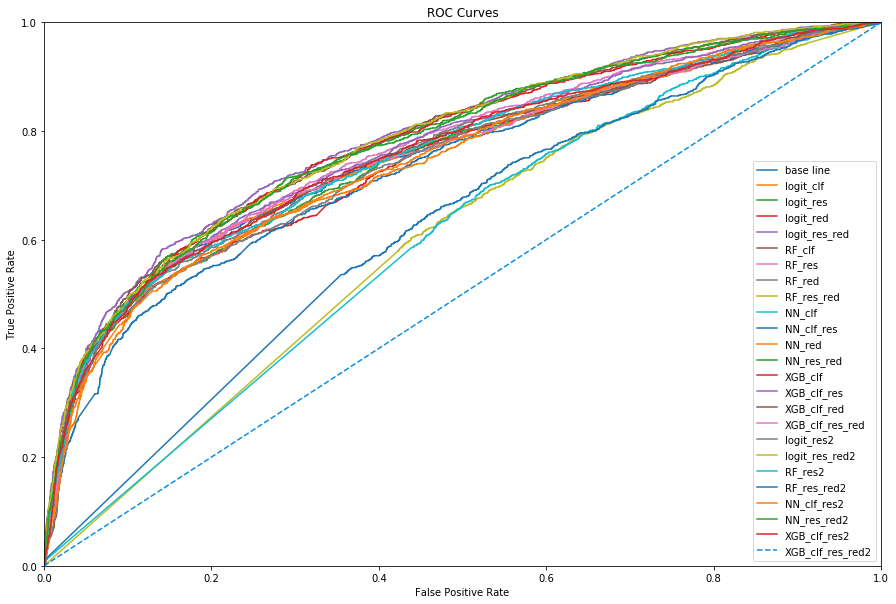

In [416]:
plt.figure(figsize=(15,10))
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves')
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        fpr,tpr,threshold = roc_curve(y_test, CLF_list[i].predict_proba(X_xgb_red_test)[:, 1])
        plt.plot(fpr, tpr, label=threshold)
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        fpr,tpr,threshold = roc_curve(y_test, CLF_list[i].predict_proba(X_xgb_test)[:, 1])
        plt.plot(fpr, tpr, label=threshold)
    elif 'red' in CLF_list_str[i]:
        fpr,tpr,threshold = roc_curve(y_test, CLF_list[i].predict_proba(X_red_test)[:, 1])
        plt.plot(fpr, tpr, label=threshold)
    else:
        fpr,tpr,threshold = roc_curve(y_test, CLF_list[i].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=threshold)
plt.plot([0, 1], [0, 1], '#0C8EE0', linestyle='--')
plt.legend(legend)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

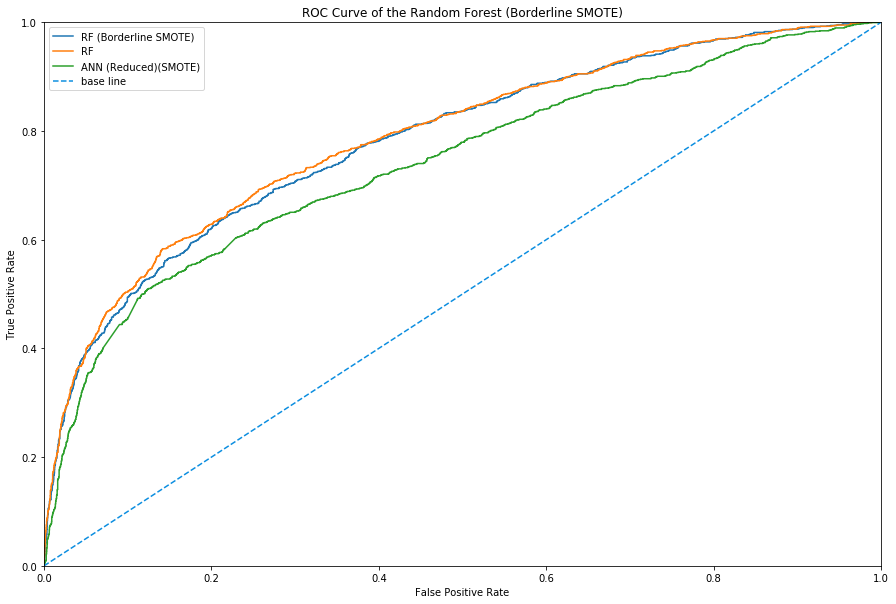

In [417]:
plt.figure(figsize=(15,10))
plt.axis([0, 1, 0, 1])
plt.title('ROC Curve of the Random Forest (Borderline SMOTE)')
fpr,tpr,threshold = roc_curve(y_test, RF_res2.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, RF_clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, NN_res_red.predict_proba(X_red_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
plt.plot([0, 1], [0, 1], '#0C8EE0', linestyle='--')
plt.legend(['RF (Borderline SMOTE)','RF','ANN (Reduced)(SMOTE)','base line'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("RF_res2.png",transparent=True)

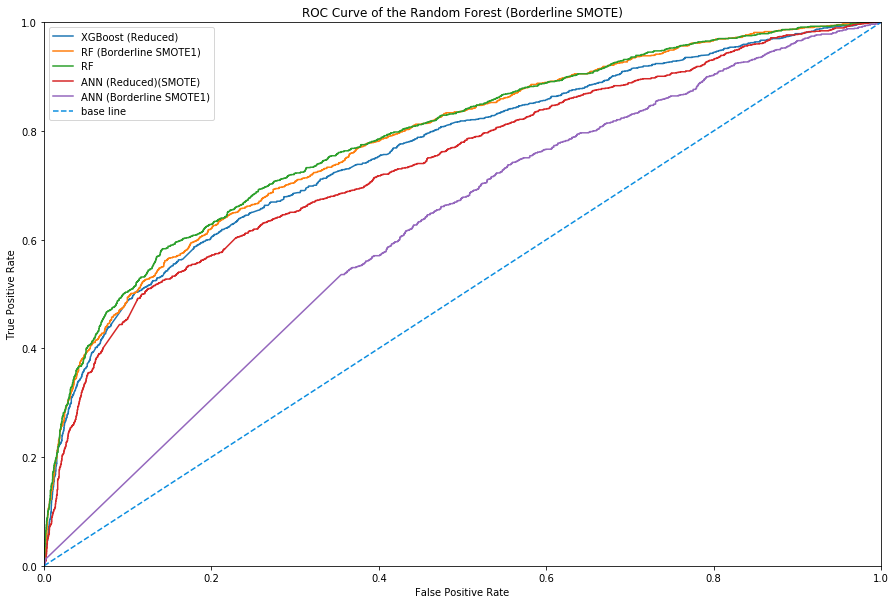

In [418]:
plt.figure(figsize=(15,10))
plt.axis([0, 1, 0, 1])
plt.title('ROC Curve of the Random Forest (Borderline SMOTE)')
fpr,tpr,threshold = roc_curve(y_test, XGB_clf_red.predict_proba(X_red_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, RF_res2.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, RF_clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, NN_res_red.predict_proba(X_red_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
fpr,tpr,threshold = roc_curve(y_test, NN_clf_res2.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=threshold)
plt.plot([0, 1], [0, 1], '#0C8EE0', linestyle='--')
plt.legend(['XGBoost (Reduced)','RF (Borderline SMOTE1)','RF','ANN (Reduced)(SMOTE)','ANN (Borderline SMOTE1)','base line'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("model_time.png",transparent=True)

# AUC Score

In [419]:
AUC_dict={}
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = roc_auc_score(y_true=y_test,y_score=CLF_list[i].predict_proba(X_xgb_red_test)[:,1])
        AUC_dict[CLF_list_str[i]]=r
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = roc_auc_score(y_true=y_test,y_score=CLF_list[i].predict_proba(X_xgb_test)[:,1])
        AUC_dict[CLF_list_str[i]]=r
    elif 'red' in CLF_list_str[i]:
        r = roc_auc_score(y_true=y_test,y_score=CLF_list[i].predict_proba(X_red_test)[:,1])
        AUC_dict[CLF_list_str[i]]=r
    else:
        r = roc_auc_score(y_true=y_test,y_score=CLF_list[i].predict_proba(X_test)[:,1])
        AUC_dict[CLF_list_str[i]]=r

In [420]:
print('AUC scores:')
for key, value in sorted(AUC_dict.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

AUC scores:
RF_clf: 0.7879874299133165
RF_res2: 0.7823572734451839
RF_res: 0.7810862833210586
XGB_clf: 0.7803363322239013
XGB_clf_res: 0.7780077828491241
XGB_clf_res2: 0.7760953712673182
RF_red: 0.7642910394027096
XGB_clf_red: 0.7640473718169007
XGB_clf_res_red2: 0.7557403390478838
RF_res_red2: 0.7551827740724143
RF_res_red: 0.7539179925532218
logit_res: 0.7532012615240173
XGB_clf_res_red: 0.7530571735108338
logit_res2: 0.7513175546611223
logit_clf: 0.7503538501655601
logit_red: 0.7442825602222584
NN_res_red2: 0.7430813161145874
logit_res_red2: 0.7418429816397845
NN_res_red: 0.7404461261611099
logit_res_red: 0.7399532274344223
NN_red: 0.7289452096258856
NN_clf_res2: 0.6152046960920138
NN_clf_res: 0.5981763472793651
NN_clf: 0.5962661127408475


# F1-score

In [421]:
F1_dict={}
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = f1_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_red_test))
        F1_dict[CLF_list_str[i]]=r
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = f1_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_test))
        F1_dict[CLF_list_str[i]]=r
    elif 'red' in CLF_list_str[i]:
        r = f1_score(y_true=y_test,y_pred=CLF_list[i].predict(X_red_test))
        F1_dict[CLF_list_str[i]]=r
    else:
        r = f1_score(y_true=y_test,y_pred=CLF_list[i].predict(X_test))
        F1_dict[CLF_list_str[i]]=r

In [422]:
print('F1 scores:')
for key, value in sorted(F1_dict.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

F1 scores:
logit_res: 0.5355618776671408
logit_res2: 0.5303945965161748
XGB_clf_res_red: 0.529304696032035
RF_res_red2: 0.5255311218784943
XGB_clf_res_red2: 0.5251594613749114
RF_res_red: 0.5230648944487881
logit_res_red: 0.5209444021325209
logit_res_red2: 0.5190207156308851
RF_res: 0.5137946630483944
RF_res2: 0.5115228197017623
NN_res_red2: 0.509979353062629
NN_res_red: 0.5033512064343163
XGB_clf_res: 0.49122807017543857
RF_clf: 0.4834834834834835
XGB_clf_res2: 0.4833659491193738
XGB_clf: 0.4733963202386872
XGB_clf_red: 0.4580384226491405
RF_red: 0.45786802030456847
logit_clf: 0.44536082474226807
logit_red: 0.4067063277447269
NN_clf_res: 0.38944422231107556
NN_clf: 0.3827392120075047
NN_clf_res2: 0.3795124961431657
NN_red: 0.08404558404558404


# F_Beta-score (Beta=3)

In [423]:
FB_dict={}
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = fbeta_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_red_test), beta=3)
        FB_dict[CLF_list_str[i]]=r
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = fbeta_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_test), beta=3)
        FB_dict[CLF_list_str[i]]=r
    elif 'red' in CLF_list_str[i]:
        r = fbeta_score(y_true=y_test,y_pred=CLF_list[i].predict(X_red_test), beta=3)
        FB_dict[CLF_list_str[i]]=r
    else:
        r = fbeta_score(y_true=y_test,y_pred=CLF_list[i].predict(X_test), beta=3)
        FB_dict[CLF_list_str[i]]=r

In [424]:
print('F_Beta=3 scores:')
for key, value in sorted(FB_dict.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

F_Beta=3 scores:
NN_clf_res2: 0.7193823839045502
NN_clf_res: 0.6236393904469202
logit_res: 0.5607685433422698
logit_res2: 0.5555141857174771
NN_res_red: 0.5522058823529412
XGB_clf_res_red2: 0.5514213424616757
NN_clf: 0.5483870967741935
NN_res_red2: 0.5479958586007987
XGB_clf_res_red: 0.5440395120856095
RF_res_red2: 0.5301150462440786
logit_res_red2: 0.5191771531911687
logit_res_red: 0.5165382872677843
RF_res_red: 0.5078184302413845
RF_res: 0.4428159351368207
RF_res2: 0.44118793358796476
XGB_clf_res: 0.3978528575939375
XGB_clf_res2: 0.39020537124802523
RF_clf: 0.38290788013318544
XGB_clf: 0.3769699849528787
XGB_clf_red: 0.35969509290138163
RF_red: 0.35833465755601457
logit_clf: 0.34405861739407456
logit_red: 0.3016446048937024
NN_red: 0.049084858569051586


# Recall

In [425]:
recall_dict={}
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = recall_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_red_test))
        recall_dict[CLF_list_str[i]]=r
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = recall_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_test))
        recall_dict[CLF_list_str[i]]=r
    elif 'red' in CLF_list_str[i]:
        r = recall_score(y_true=y_test,y_pred=CLF_list[i].predict(X_red_test))
        recall_dict[CLF_list_str[i]]=r
    else:
        r = recall_score(y_true=y_test,y_pred=CLF_list[i].predict(X_test))
        recall_dict[CLF_list_str[i]]=r

In [426]:
for key, value in sorted(recall_dict.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

NN_clf_res2: 0.9269027882441597
NN_clf_res: 0.7339864355689525
NN_clf: 0.6149208741522231
logit_res: 0.5674453654860587
NN_res_red: 0.5659382064807837
logit_res2: 0.5621703089675961
NN_res_red2: 0.5584024114544084
XGB_clf_res_red2: 0.5584024114544084
XGB_clf_res_red: 0.5478522984174831
RF_res_red2: 0.5312735493594575
logit_res_red2: 0.519216277317257
logit_res_red: 0.5154483798040693
RF_res_red: 0.5041446872645065
RF_res: 0.42803315749811605
RF_res2: 0.426525998492841
XGB_clf_res: 0.37980406932931426
XGB_clf_res2: 0.37226827430293896
RF_clf: 0.36397889977392617
XGB_clf: 0.35870384325546345
XGB_clf_red: 0.3413715146948003
RF_red: 0.3398643556895252
logit_clf: 0.3255463451394122
logit_red: 0.28334589299171065
NN_red: 0.044461190655614165


# Precision

In [427]:
precision_dict={}
for i in range(len(CLF_list)):
    if 'red' in CLF_list_str[i] and 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = precision_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_red_test))
        precision_dict[CLF_list_str[i]]=r
    elif 'XGB' in CLF_list_str[i] and 'res' in CLF_list_str[i]:
        r = precision_score(y_true=y_test,y_pred=CLF_list[i].predict(X_xgb_test))
        precision_dict[CLF_list_str[i]]=r
    elif 'red' in CLF_list_str[i]:
        r = precision_score(y_true=y_test,y_pred=CLF_list[i].predict(X_red_test))
        precision_dict[CLF_list_str[i]]=r
    else:
        r = precision_score(y_true=y_test,y_pred=CLF_list[i].predict(X_test))
        precision_dict[CLF_list_str[i]]=r

In [428]:
for key, value in sorted(precision_dict.items(), key=lambda item: item[1], reverse=True):
    print("%s: %s" % (key, value))

NN_red: 0.7662337662337663
logit_red: 0.7203065134099617
RF_clf: 0.7198211624441133
logit_clf: 0.7047308319738989
RF_red: 0.7013996889580093
XGB_clf: 0.695906432748538
XGB_clf_red: 0.695852534562212
XGB_clf_res: 0.6951724137931035
XGB_clf_res2: 0.6889818688981869
RF_res: 0.6425339366515838
RF_res2: 0.6388261851015802
RF_res_red: 0.5434606011372868
logit_res_red: 0.5265588914549654
RF_res_red2: 0.5199115044247787
logit_res_red2: 0.5188253012048193
XGB_clf_res_red: 0.5119718309859155
logit_res: 0.5070707070707071
logit_res2: 0.5020188425302826
XGB_clf_res_red2: 0.4956521739130435
NN_res_red2: 0.46928435718809375
NN_res_red: 0.4532287266143633
NN_clf: 0.27783452502553624
NN_clf_res: 0.26503401360544215
NN_clf_res2: 0.23860329776915615
